In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Found 2105 files belonging to 2 classes.
Using 1684 files for training.
Found 2105 files belonging to 2 classes.
Using 421 files for validation.


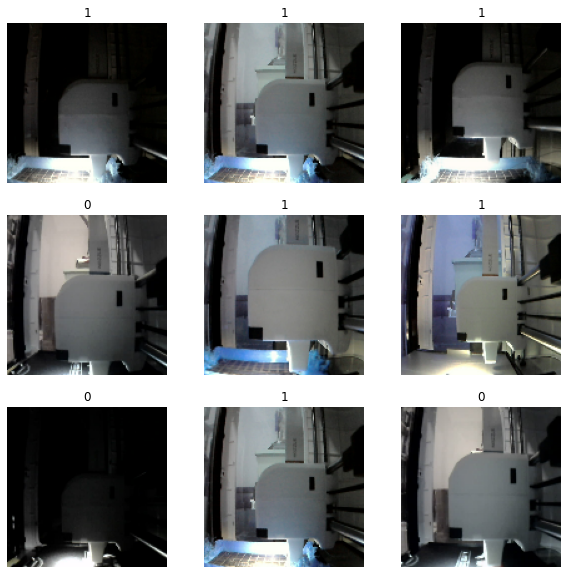

In [10]:
image_size = (128, 128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "classes",
    seed=1337,
    subset="training",
    validation_split=0.2,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "classes",
    seed=1337,
    subset="validation",
    validation_split=0.2,
    image_size=image_size,
    batch_size=batch_size,
)

classes = 2

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [11]:
#convert the color space from 0-255 to 0-1
train_ds = train_ds.map(lambda image, label: (tf.cast(image, tf.float32) / 255.0, label))
val_ds = val_ds.map(lambda image, label: (tf.cast(image, tf.float32) / 255.0, label))

#One hot encode the labels
train_ds = train_ds.map(lambda image, label: (image, tf.one_hot(label, depth=classes))) #the depth parameter is the number of classes
val_ds = val_ds.map(lambda image, label: (image, tf.one_hot(label, depth=classes)))

#Optimizer for the memory
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
    

In [12]:
model = tf.keras.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(classes, activation='softmax')
])

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

#load weights
# model.load_weights('model.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)            

In [13]:
history = model.fit(train_ds, validation_data=val_ds, epochs=6)

#save the model
model.save('model.h5')

Epoch 1/6
53/53 [==============================] - 20s 356ms/step - loss: 0.2118 - accuracy: 0.9115 - val_loss: 0.0393 - val_accuracy: 0.9905
Epoch 2/6
53/53 [==============================] - 19s 356ms/step - loss: 0.0230 - accuracy: 0.9923 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 3/6
53/53 [==============================] - 19s 351ms/step - loss: 0.0060 - accuracy: 0.9976 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 4/6
53/53 [==============================] - 19s 353ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.9190e-04 - val_accuracy: 1.0000
Epoch 5/6
53/53 [==============================] - 19s 353ms/step - loss: 2.3404e-04 - accuracy: 1.0000 - val_loss: 6.9775e-05 - val_accuracy: 1.0000
Epoch 6/6
53/53 [==============================] - 19s 347ms/step - loss: 1.0250e-04 - accuracy: 1.0000 - val_loss: 3.6899e-05 - val_accuracy: 1.0000


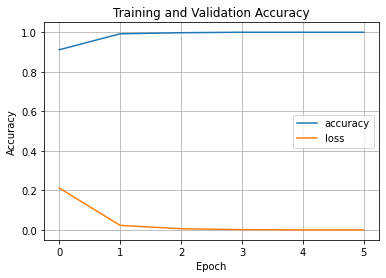

EVALUATION RESULTS
14/14 [==============================] - 1s 79ms/step - loss: 3.6899e-05 - accuracy: 1.0000


[3.689852746902034e-05, 1.0]

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.legend(['accuracy', 'loss'])

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.grid()
plt.show()

#evaluate the model
print("EVALUATION RESULTS")
model.evaluate(val_ds)

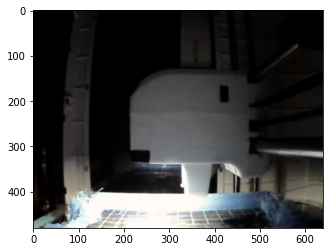

In [15]:
#import opencv
import cv2

ip = "192.168.0.130"
adress = "http://" + ip + ":8080/?action=stream"

#load the image from the camera
cap = cv2.VideoCapture(adress)
#get the first frame
ret, img = cap.read()
#close the camera
cap.release()

#show the image in matplotlib
plt.imshow(img)

In [16]:
def getWarningLevel(img):
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    #resize the image to 64x64
    img_array = tf.image.resize(img_array, (128, 128))

    #convert the color space from 0-255 to 0-1
    img_array = tf.cast(img_array, tf.float32) / 255.0

    predictions = model.predict(img_array)
    return predictions[0][1]

val = getWarningLevel(img)
#round the value to 2 decimal places
val = round(val, 6)*100
print("The warning level is: " + str(val), "%")

The warning level is: 99.99960064888 %
